# 09: Hail Average Magnitude Forecast | Region: U.S. Midwest
---

## 1. Imports

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [19]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [20]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [21]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [22]:
# Casting the begin_date_time to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [23]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Hail in the Midwest (2000-2022)

In [24]:
hail = all_storms[all_storms['event_type'] == 'Hail']

hail = hail[hail['region'] == 'Midwest']

hail = hail[hail.index > '2000']

In [25]:
hail

,state,region,event_type,magnitude
begin_date_time,,,,
2000-01-03 03:00:00,Missouri,Midwest,Hail,0.88
2000-01-03 03:50:00,Missouri,Midwest,Hail,0.75
2000-01-03 09:15:00,Illinois,Midwest,Hail,0.88
2000-01-03 10:10:00,Illinois,Midwest,Hail,0.75
2000-01-03 13:15:00,Indiana,Midwest,Hail,0.75
...,...,...,...,...
2022-03-29 19:03:00,Kansas,Midwest,Hail,0.88
2022-03-29 19:15:00,Kansas,Midwest,Hail,1.00
2022-03-29 19:22:00,Kansas,Midwest,Hail,0.88


### 3.3. Resampling to Quarterly Averages

In [26]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [27]:
# Resampling to quarterly averages
hail = hail.resample('Q').mean()

# Renaming the column to 'avg_mag'
hail = hail.rename(columns={'magnitude': 'avg_mag'})

In [28]:
# Checking for null values as a result of the resampling

hail.isnull().sum()

avg_mag    0
dtype: int64

In [30]:
hail

,avg_mag
begin_date_time,
2000-03-31,0.942280
2000-06-30,1.120886
2000-09-30,1.103755
2000-12-31,0.954046
2001-03-31,0.833400
...,...
2021-03-31,1.081754
2021-06-30,1.249991
2021-09-30,1.362579


Resampling to quarterly timeframes results in 89 observations.

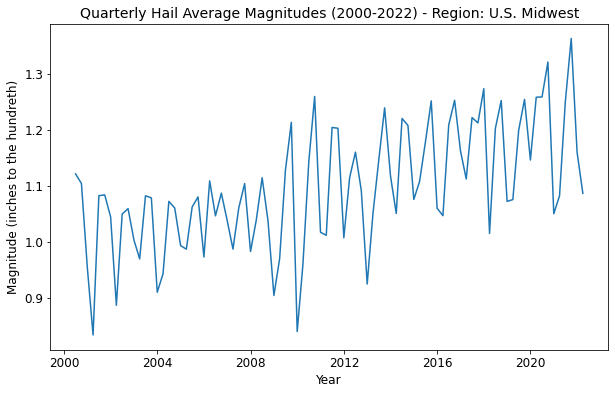

In [56]:
# Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. Midwest

plot_series(hail, ['avg_mag'], title='Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. Midwest', xlab='Year', ylab='Magnitude (inches to the hundreth)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

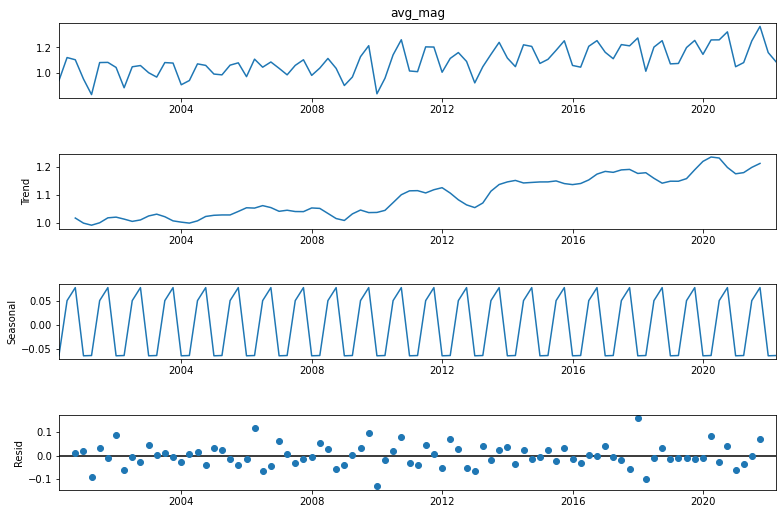

In [32]:
decomp = seasonal_decompose(hail['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see that the averages have increased over time.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model.

### 4.2. Autocorrelation

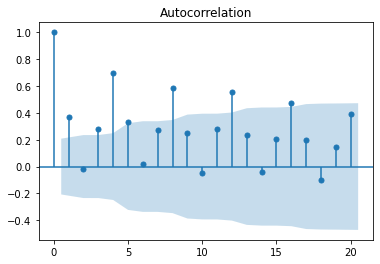

In [33]:
plot_acf(hail['avg_mag']);

For trend, a few of the earlier lags do extend beyond the blue region, which represents a 95% confidence interval, meaning that there do seem to be trends present in the data.

For seasonality, the fluctuations do seem to occur with a fixed and known frequency and therefore, indicates that there may be seasonality present in the data.

For lags, it seems that using the first lag will be useful to include in the model, as it extends beyond the blue region. While there are later lags that also extend beyond the blue region, there are lags in between them that do not, thereby making them lags that are not likely to improve model performance.

### 4.3. Partial Autocorrelation

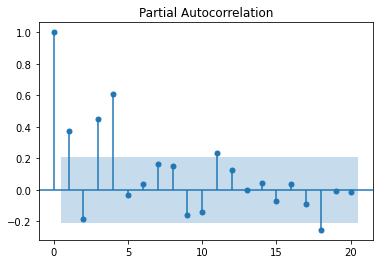

In [34]:
plot_pacf(hail['avg_mag']);

For seasonality, contrary to the autocorrelation, the fluctuations no longer occur with a fixed and known frequency and therefore, determines that there is no seasonality present.

For lags, the amount that extend beyond the blue region has been reduced. The 1st, 3rd and 4th lag all continue to extend beyond the blue region, but given that the second lag does not, it continues to be likely that only the first lag will be useful.

### 4.4. Stationarity

In [35]:
# Dickey-Fuller Stationarity Test

adfuller(hail['avg_mag'])

(0.15047755899745857,
 0.9693431779247165,
 11,
 77,
 {'1%': -3.518281134660583,
  '5%': -2.899878185191432,
  '10%': -2.5872229937594873},
 -184.44883172984566)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

In [36]:
# Differencing the data

hail['first_diff'] = hail['avg_mag'].diff()

In [37]:
# Dropping any null values as a result of the differencing

hail.dropna(inplace=True)

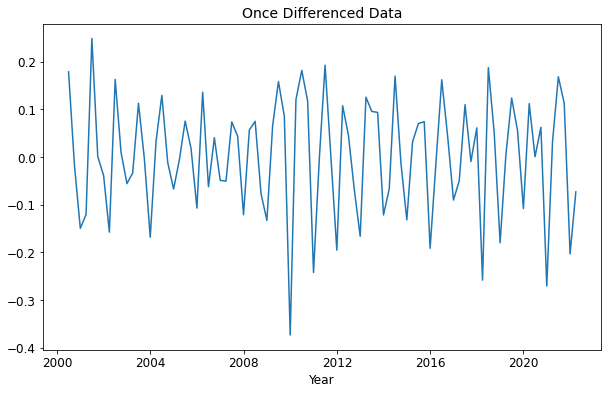

In [38]:
plot_series(hail, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [39]:
# Checking for the stationarity of the once differenced data

adfuller(hail['first_diff'])

(-5.550643924763582,
 1.622786637347055e-06,
 10,
 77,
 {'1%': -3.518281134660583,
  '5%': -2.899878185191432,
  '10%': -2.5872229937594873},
 -182.66453278475626)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

As with the thunderstorm data, considering the few observations that I have to work with, I'll be using 90% of the data to train on.

In [40]:
y_train, y_test = train_test_split(hail['first_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data once, I know that the d parameter for the ARIMA model is 1. Given that, I'll run a GridSearch for the most optimal p & q.

In [41]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 1, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,1,0) is: -40.51811515011238
The AIC for ARIMA(0,1,1) is: -99.97729644865754


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,1,2) is: -141.86569815313342
The AIC for ARIMA(0,1,3) is: -142.1967049249076
The AIC for ARIMA(0,1,4) is: -156.11295490126378
The AIC for ARIMA(1,1,0) is: -46.72412515680386
The AIC for ARIMA(1,1,1) is: -100.33505288700871
The AIC for ARIMA(1,1,2) is: -96.0611288342149
The AIC for ARIMA(1,1,3) is: -138.59254200604138
The AIC for ARIMA(1,1,4) is: -139.2822555491962
The AIC for ARIMA(2,1,0) is: -72.95375965988303
The AIC for ARIMA(2,1,1) is: -139.9141363477839
The AIC for ARIMA(2,1,2) is: -174.3610848339144
The AIC for ARIMA(2,1,3) is: -174.01641846070902
The AIC for ARIMA(2,1,4) is: -190.95691743724456
The AIC for ARIMA(3,1,0) is: -139.1109559170889
The AIC for ARIMA(3,1,1) is: -183.56718204389784
The AIC for ARIMA(3,1,2) is: -182.77533824727584
The AIC for ARIMA(3,1,3) is: -180.81497061509185
The AIC for ARIMA(3,1,4) is: -185.96953053156793
The AIC for ARIMA(4,1,0) is: -159.22000776269823


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(4,1,1) is: -182.7382690037262
The AIC for ARIMA(4,1,2) is: -180.28645051134927
The AIC for ARIMA(4,1,3) is: -178.77638873103322
The AIC for ARIMA(4,1,4) is: -178.4882997495511


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of -190.95691743724456.


The p, d, q combination that returned the lowest AIC was when p=2, d=1, and q=4. This means that the model will perform best with the use of 2 lags, once differenced data, and a moving average window of 4. As such, the order of (2,1,4) will be used in the ARIMA model.

### 5.3. Instantiate & Fit

In [42]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (2,1,4))

arima = model.fit()

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5.4. Test Forecast

In [43]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

9

In [55]:
# Generating the forecast for those 9 quarters

forecast = arima.forecast(steps=9)
forecast

2020-03-31   -0.009662
2020-06-30    0.116675
2020-09-30    0.029414
2020-12-31   -0.108597
2021-03-31   -0.022170
2021-06-30    0.115699
2021-09-30    0.030103
2021-12-31   -0.107621
2022-03-31   -0.022853
Freq: Q-DEC, Name: predicted_mean, dtype: float64

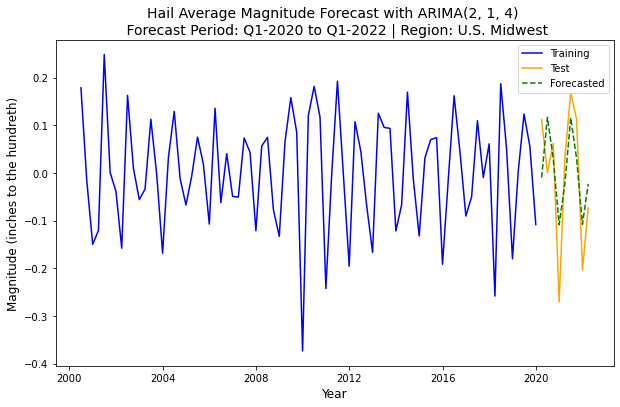

In [46]:
# Hail Average Magnitude Forecast with ARIMA(2, 1, 4) - Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. Midwest

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Hail Average Magnitude Forecast with ARIMA(2, 1, 4) \n Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. Midwest', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Magnitude (inches to the hundreth)', fontsize=12)

plt.legend();

Visually, the model seems to have forecasted well. It does attempt to follow the increases and decreases, though not to their full extent.

### 5.5. Test Evaluation

In [47]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: 0.5514430219846597


The model is able to explain 55% of the variability in the data.

In [49]:
rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 0.09418090280343484


In [50]:
hail.describe()

,avg_mag,first_diff
count,88.000000,88.000000
mean,1.095416,0.001635
std,0.109364,0.123046
min,0.833400,-0.373424
25%,1.037258,-0.070014
50%,1.081932,0.006466
75%,1.182489,0.094059
max,1.362579,0.248608


The RMSE of 0.09 did not exceed the standard deviation of 0.12. This model's forecasts are reliable by these evaluation metric's standards.